This implements the first model fit, the "original fundamental plane" fit as referred to in the paper.

# Basic settings

In [1]:
globalseed = 0

In [2]:
masscut = 10**9

In [3]:
runname = "OrigFunPlane"

PPRpredsuse = ['iband Mag','log sigma_v']

predsscl = []

In [4]:
file_dir='./temp/ChadAnalyses/'+runname+'/'

### Settings that are fixed across runs

In [5]:
traintestseed = globalseed

# Import Packages

In [6]:
%pylab inline

import illustris_python as il
import pandas as pd
import pickle

import os

from astropy.table import Table

from matplotlib.colors import LogNorm

Populating the interactive namespace from numpy and matplotlib


In [7]:
#from numpy.random import seed
np.random.seed(globalseed)

In [8]:
basePath= '/hildafs/datasets/IllustrisTNG/TNG100-1/output'
snapNum=99 #refers to final snapshot, redshift of zero

# Create the combined catalog

Start with data from the base Illustris catalog.

See https://www.tng-project.org/data/docs/specifications/#sec2b

These are the fields that will be extracted from this catalog.

In [9]:
addvariables = ['SubhaloBHMass','SubhaloGasMetallicity','SubhaloSFR',
                'SubhaloStarMetallicity','SubhaloVmax']

In [10]:
fields = ['SubhaloGrNr',
          'SubhaloFlag',
          'SubhaloMassType',
          'SubhaloPos',
          'SubhaloStellarPhotometrics',
          'SubhaloMassInHalfRad',
          'SubhaloHalfmassRad',
          'SubhaloHalfmassRadType'] + addvariables

In [11]:
subhalos=il.groupcat.loadSubhalos(basePath,snapNum,fields=fields)

This is here just for reference:

0. PartType0 - GAS
1. PartType1 - DM
2. PartType2 - (unused)
3. PartType3 - TRACERS
4. PartType4 - STARS & WIND PARTICLES
5. PartType5 - BLACK HOLES

### Read in additional catalogs

The velocity dispersion catalog.

In [12]:
df_non_red_100_subfind_sigma_v = pd.DataFrame(pickle.load(
    open('/hildafs/datasets/IllustrisTNG/TNG100-1/TNG100-1_99_galaxy_vel_disp_100.0.p', 
         "rb" ) ))

print(df_non_red_100_subfind_sigma_v.shape)
df_non_red_100_subfind_sigma_v.head()

(20051, 5)


,gal_id,Lx,Ly,Lz,sigma_v
0,0.0,-9.085662,-7.872045,-4.559502,374.378662
1,1.0,1.795185,-0.857926,1.563985,214.005508
2,2.0,0.620052,2.585010,0.742175,196.719849
3,3.0,0.292968,-0.387597,-1.368885,106.750359
4,4.0,-0.058817,0.112009,-0.858557,116.125282


The "full" catalog.

In [13]:
df_non_red_100_subfind_full = pickle.load(
    open('/hildafs/datasets/IllustrisTNG/TNG100-1/TNG100-1_99_galaxy_component_shapes_3I_subfind_FULL_mass-cut9.p', 
         "rb" ) )

print(df_non_red_100_subfind_full.shape)
df_non_red_100_subfind_full.head()

(20051, 114)


,gal_id,f_disk,int_disk_thin,int_disk_thick,int_disk_counter_exp2,chisq_exp2,int_disk_exp1,int_disk_counter_exp1,chisq_exp1,mc_disk,...,bv_z,cv_x,cv_y,cv_z,mass,gal_pos_x,gal_pos_y,gal_pos_z,e1,e2
0,0.0,0.102826,1.120683e-11,0.252965,0.090781,69.553006,0.359817,0.198626,54.325447,0.229510,...,0.377225,0.782535,0.612006,0.114402,3.705585e+12,0.849091,26.326996,18.306934,-0.109703,-0.157248
1,1.0,0.073827,5.167568e-03,0.082322,0.064100,287.146480,0.208253,0.173610,272.848191,0.084007,...,0.469768,-0.159400,0.476258,-0.864737,5.587917e+11,0.106473,24.633322,16.900553,0.295580,0.009956
2,2.0,0.104297,5.651366e-02,0.208010,0.100389,63.551982,0.203645,0.071742,77.861395,0.237992,...,-0.293690,0.135702,0.904910,0.403390,6.271396e+11,0.853112,26.725748,17.510679,0.026402,-0.016790
3,3.0,0.293960,3.609416e-01,0.187110,0.037387,72.289555,0.448154,0.028169,967.551351,0.564971,...,-0.012360,-0.111798,0.556926,0.823003,1.715515e+11,0.245455,26.517372,15.888749,-0.066341,-0.033003
4,4.0,0.158796,7.771672e-02,0.102280,0.022292,72.560206,0.135537,0.005955,184.095625,0.199667,...,0.015853,-0.002944,-0.163988,0.986458,1.333404e+11,0.768784,26.518290,15.530523,-0.028562,0.007162


Note that, for some reason, `gal_id` appears twice in the "full" catalog. Hence, the `drop` function removes both of those instances. It's for this reason that I am dropping from the "full" catalog, and not from the velocity dispersion catalog.

In [14]:
fullinfo = pd.concat(
    [df_non_red_100_subfind_full.drop({'gal_id'},axis=1),
     df_non_red_100_subfind_sigma_v], 
     axis=1)

### Create the merged catalog

For each variable in the base catalog, need to extract the elements based on `gal_id` in the supplemental catalog.

The photometric magnitudes.

In [15]:
fullinfo['gband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),4]
fullinfo['rband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),5]
fullinfo['iband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),6]
fullinfo['zband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),7]

Colors

In [16]:
fullinfo['g - r'] = fullinfo['gband Mag'] - fullinfo['rband Mag']
fullinfo['r - i'] = fullinfo['rband Mag'] - fullinfo['iband Mag']
fullinfo['i - z'] = fullinfo['iband Mag'] - fullinfo['zband Mag']

Size and mass. (Mass measures stars.)

In [17]:
fullinfo['size'] = subhalos['SubhaloHalfmassRad'][fullinfo['gal_id'].astype('int')]
fullinfo['galaxy_mass'] = \
     subhalos['SubhaloMassType'][fullinfo['gal_id'].astype('int'),4]*10**10

Other variables from the base catalog.

In [18]:
for addvar in addvariables:
    fullinfo[addvar] = subhalos[addvar][fullinfo['gal_id'].astype('int')]

The subhalo flag is mapped over, in order to exclude flagged observations.

In [19]:
fullinfo['subhaloflag'] = subhalos['SubhaloFlag'][fullinfo['gal_id'].astype('int')]

There are some duplicated columns. Note that the data in them were not actually identical. In particular, the position variables were off by a factor of 1000.

In [20]:
fullinfo = fullinfo.loc[:,~fullinfo.columns.duplicated()]

Exclude any observations for which the `SubhaloFlag` is `False` or the mass is not sufficiently large. If mass cutoff is $10^9$, there should be 17513 rows remaining. If the mass cutoff is $10^{10}$, there should be 4987 rows remaining.

In [21]:
keep = (fullinfo['subhaloflag']) & (fullinfo['galaxy_mass'] > masscut) 
print(sum(keep))

subinfo = fullinfo[keep].copy()

17513


Create log-transformed versions of some variables.

In [22]:
varsToLogTransform = ['galaxy_mass',
                      'sigma_v',
                      'size']

for varname in varsToLogTransform:
    subinfo['log ' + varname] = log10(subinfo[varname])

In [23]:
respuse = 'log size'

## Split into Test and Training Sets

In [24]:
from sklearn.model_selection import train_test_split

This first split is specifically to take into consideration the use of the predicted values for central versus sattelite galaxies. The "training set" for the purpose of fitting the model for predicting central versus sattelite should not be used in the downstream analyses.

Note that the seed was (arbitrarily) set to 21 to match that used in the code where the CS model is fit.

In [25]:
train_featuresCS, test_featuresCS, train_labelsCS, test_labelsCS = \
   train_test_split(subinfo[PPRpredsuse], subinfo[respuse], 
   test_size = 0.70, random_state = 21)
    
train_features, test_features, train_labels, test_labels = \
   train_test_split(test_featuresCS, test_labelsCS, 
   test_size = 0.2, random_state = traintestseed)

    
train_features = train_features.astype(float)
test_features = test_features.astype(float)

# Projection Pursuit Regression

In [26]:
#pip install projection-pursuit
from skpp import ProjectionPursuitRegressor

Always a good idea to inspect the distribution of the predictors.

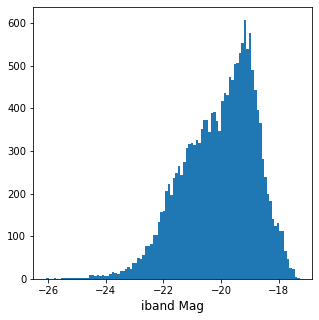

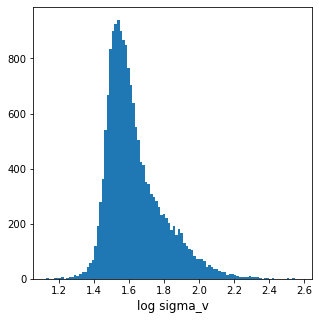

In [27]:
for pred in PPRpredsuse:
    plt.figure(figsize=[5,5])
    hist(subinfo[pred], bins=100)
    plt.xlabel(pred,size=12)
    plt.show()

Fit the model. Start by setting the number of ridge functions, and the degree of the splines.

In [28]:
ruse = 1
deguse = 3

In [29]:
PPRestimatorsplit = ProjectionPursuitRegressor(r=ruse,
        show_plots=False, degree=deguse, fit_type='spline',
        random_state=globalseed)

PPRestimatorsplit.fit(train_features,train_labels)

ProjectionPursuitRegressor(fit_type='spline', r=1, random_state=0)

This is the projection of the data using the alpha vectors, i.e., this is prior to the application of the nonlinear functions.

In [30]:
projs = PPRestimatorsplit.transform(train_features)

Determine the fits from each projection.

In [31]:
fitsbyproj = projs.copy()
for i in range(ruse):
    fitsbyproj[:,i] = PPRestimatorsplit._f[i](projs[:,i])*PPRestimatorsplit._beta[0][i]

Calculate the fitted values and residuals, but also compare with what's returned by `predict`, as a double check.

In [32]:
fittedvalues = fitsbyproj.sum(1)
residuals = train_labels - fittedvalues

print(fittedvalues)
print(PPRestimatorsplit.predict(train_features))

[1.14534883 1.24446237 1.21266448 ... 1.42735039 1.40836654 1.44515133]
[1.14534883 1.24446237 1.21266448 ... 1.42735039 1.40836654 1.44515133]


I made this check to simply confirm that there is no overall intercept term being fit.

In [33]:
fittedvalues - PPRestimatorsplit._f[0](projs[:,0])*PPRestimatorsplit._beta[0][0]

array([0., 0., 0., ..., 0., 0., 0.])

This illustrates how each nonlinear function is fit to the residuals of the other fits.

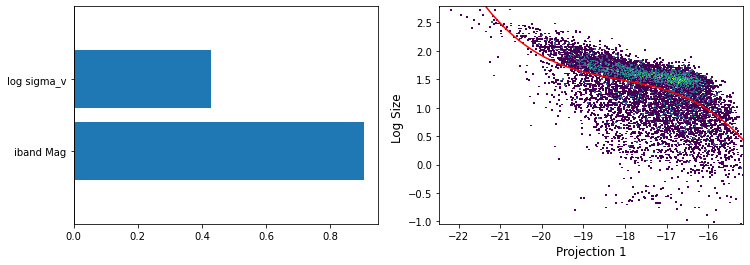

In [34]:
for i in range(ruse):
    
    # The residuals from the fit leaving out projection i
    residswithouti = residuals + fitsbyproj[:,i]
    
    fig,axs = plt.subplots(1,2,figsize=[12,4])
    
    axs[0].barh(PPRpredsuse, PPRestimatorsplit._alpha[:,i])
    axs[0].plot([0, 0], [-5, len(PPRpredsuse)+5], 'k-')
    axs[0].set(ylim=(-1,len(PPRpredsuse)))
    
    axs[1].hist2d(x=projs[:,i],
       y=residswithouti,
         bins=300,
         norm=matplotlib.colors.LogNorm())

    foo = PPRestimatorsplit._f[i](sort(projs[:,i]))*PPRestimatorsplit._beta[0][i]

    plot(sort(projs[:,i]),foo,color="r")
    plt.title('')
    plt.ylabel('Log Size ',size=12)
    plt.xlabel(('Projection '+str(i+1)),size=12)
    plt.show()

The fitted values for alpha.

In [45]:
print(PPRestimatorsplit._alpha)

[[0.90427944]
 [0.42694109]]


Plot of residuals versus fitted values.

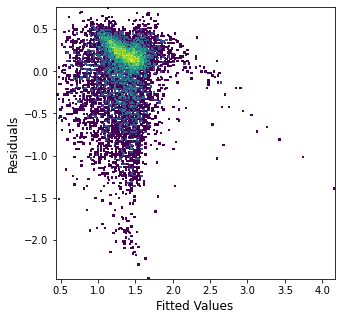

In [46]:
plt.figure(figsize=[5,5])
hist2d(x=fittedvalues,
       y=residuals,
         bins=200,
         norm=matplotlib.colors.LogNorm())
plt.title('')
plt.ylabel('Residuals',size=12)
plt.xlabel('Fitted Values',size=12)
plt.show()

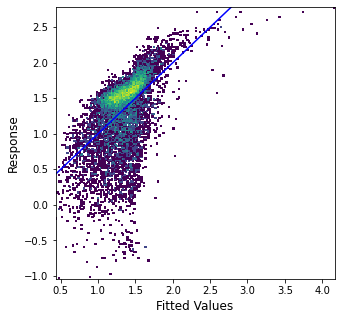

In [47]:
plt.figure(figsize=[5,5])
hist2d(x=fittedvalues,
       y=train_labels,
         bins=200,
         norm=matplotlib.colors.LogNorm())
plt.title('')
plt.ylabel('Response',size=12)
plt.xlabel('Fitted Values',size=12)
plt.plot([-100, 100], [-100, 100], 'b-')

plt.show()

### Performance on test set

In [48]:
PPRfitsontest = PPRestimatorsplit.predict(test_features)

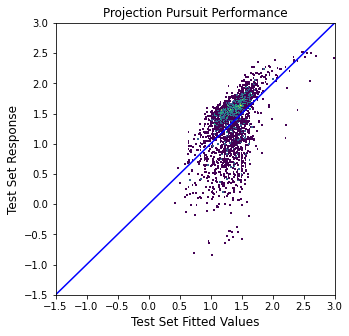

In [49]:
plt.figure(figsize=[5,5])
hist2d(x=PPRfitsontest,
       y=test_labels,
         bins=200,
         norm=matplotlib.colors.LogNorm())
plt.title('Projection Pursuit Performance')
plt.ylabel('Test Set Response',size=12)
plt.xlabel('Test Set Fitted Values',size=12)
plt.plot([-100, 100], [-100, 100], 'b-')
plt.xlim(-1.5,3)
plt.ylim(-1.5,3)

plt.show()

RMSE

In [50]:
print("RMSE PPR on test set:",round(sqrt(mean((PPRfitsontest-test_labels)**2)),3))

print("RMSE PPR on training set:",round(sqrt(mean(residuals**2)),3))

RMSE PPR on test set: 0.398
RMSE PPR on training set: 0.405


Refit the model using the full data set. Calculate and store the residuals.

In [41]:
PPRestimatorfull = ProjectionPursuitRegressor(r=ruse,show_plots=False,
            degree=deguse, fit_type='spline',random_state=globalseed)

PPRestimatorfull.fit(subinfo[PPRpredsuse].astype(float),subinfo[respuse])

ProjectionPursuitRegressor(fit_type='spline', r=1, random_state=0)

In [42]:
subinfo['PPRresids'] = subinfo[respuse] - PPRestimatorfull.predict(subinfo[PPRpredsuse].astype(float))

print(mean(subinfo['PPRresids']))
print(std(subinfo['PPRresids']))

2.526044458648103e-05
0.4027798568030287


This will create columns in the main data frame which equal the nonparametric function applied to the projection. This is done for both the fits from the full data set, and from the fits from the training/test split.

In [43]:
projsfull = PPRestimatorfull.transform(subinfo[PPRpredsuse])

for i in range(ruse):
    subinfo['PPRcompfull' + chr(i+ord('0'))] = \
       PPRestimatorfull._f[i](projsfull[:,i].astype(float))*PPRestimatorfull._beta[0][i]
    
    
projssplit = PPRestimatorsplit.transform(subinfo[PPRpredsuse])

for i in range(ruse):
    subinfo['PPRcompsplit' + chr(i+ord('0'))] = \
       PPRestimatorsplit._f[i](projssplit[:,i].astype(float))*PPRestimatorsplit._beta[0][i]

In [44]:
subinfo.head()

,f_disk,int_disk_thin,int_disk_thick,int_disk_counter_exp2,chisq_exp2,int_disk_exp1,int_disk_counter_exp1,chisq_exp1,mc_disk,a_simple_disk,...,SubhaloSFR,SubhaloStarMetallicity,SubhaloVmax,subhaloflag,log galaxy_mass,log sigma_v,log size,PPRresids,PPRcompfull0,PPRcompsplit0
0,0.102826,1.120683e-11,0.252965,0.090781,69.553006,0.359817,0.198626,54.325447,0.229510,0.263015,...,2.227189,0.028622,999.385132,True,12.399702,2.573311,2.783879,-1.288939,4.072818,4.166169
1,0.073827,5.167568e-03,0.082322,0.064100,287.146480,0.208253,0.173610,272.848191,0.084007,0.093535,...,0.413285,0.021265,514.775879,True,11.578095,2.330425,2.478507,0.216780,2.261727,2.300565
2,0.104297,5.651366e-02,0.208010,0.100389,63.551982,0.203645,0.071742,77.861395,0.237992,0.038423,...,17.392204,0.025407,461.641266,True,11.628209,2.293848,1.893481,-0.604014,2.497495,2.529409
3,0.293960,3.609416e-01,0.187110,0.037387,72.289555,0.448154,0.028169,967.551351,0.564971,0.017284,...,5.079380,0.023964,291.936554,True,11.065240,2.028369,2.037310,0.062109,1.975201,1.979273
4,0.158796,7.771672e-02,0.102280,0.022292,72.560206,0.135537,0.005955,184.095625,0.199667,0.018827,...,1.414690,0.020044,294.432983,True,10.955807,2.064927,1.930471,0.201003,1.729468,1.740794
